In [2]:
import os
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# === 1. Load Pretrained Wav2Vec2 ===
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
model.eval()

# === 2. Define Dataset Paths ===
DATA_PATH = [
    '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24',
    '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24'
]

emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# === 3. Feature Extraction ===
def extract_wav2vec_embedding(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X, y = [], []

for path in DATA_PATH:
    for actor in os.listdir(path):
        actor_folder = os.path.join(path, actor)
        if not os.path.isdir(actor_folder):
            continue
        for file in os.listdir(actor_folder):
            if file.endswith(".wav"):
                emotion_id = file.split('-')[2]
                emotion = emotion_map.get(emotion_id)
                if emotion:
                    file_path = os.path.join(actor_folder, file)
                    try:
                        emb = extract_wav2vec_embedding(file_path)
                        X.append(emb)
                        y.append(emotion)
                    except Exception as e:
                        print(f"Failed on {file_path}: {e}")

X = np.array(X)
y = np.array(y)
print("Total samples:", len(X))

# === 4. Encode Labels ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Total samples: 2452


In [3]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(le.classes_))

# === 5. Train-Test Split ===
x_train, x_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

# === 6. Build MLP Classifier ===
mlp = Sequential([
    Dense(512, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

# === 7. Train ===
early_stop = EarlyStopping(patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4)

history = mlp.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=90,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

#


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,112 (2.01 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2046 - loss: 2.0350 - val_accuracy: 0.2607 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 2/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3092 - loss: 1.7788 - val_accuracy: 0.3727 - val_loss: 1.5856 - learning_rate: 0.0010
Epoch 3/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3690 - loss: 1.6067 - val_accuracy: 0.3910 - val_loss: 1.5204 - learning_rate: 0.0010
Epoch 4/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4013 - loss: 1.5201 - val_accuracy: 0.4175 - val_loss: 1.4717 - learning_rate: 0.0010
Epoch 5/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4245 - loss: 1.5055 - val_accuracy: 0.4908 - val_loss: 1.3401 - learning_rate: 0.0010
Epoch 6/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4910 - loss: 1.3537 - val_accuracy: 0.5356 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 7/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4814 - loss: 1.3508 - val_accuracy: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:

              precision    recall  f1-score   support

       angry       0.83      0.80      0.82        75
        calm       0.73      0.72      0.72        75
     disgust       0.69      0.74      0.72        39
     fearful       0.69      0.67      0.68        75
       happy       0.63      0.69      0.66        75
     neutral       0.70      0.74      0.72        38
         sad       0.60      0.61      0.61        75
   surprised       0.62      0.51      0.56        39

    accuracy                           0.69       491
   macro avg       0.69      0.69      0.69       491
weighted avg       0.69      0.69      0.69       491



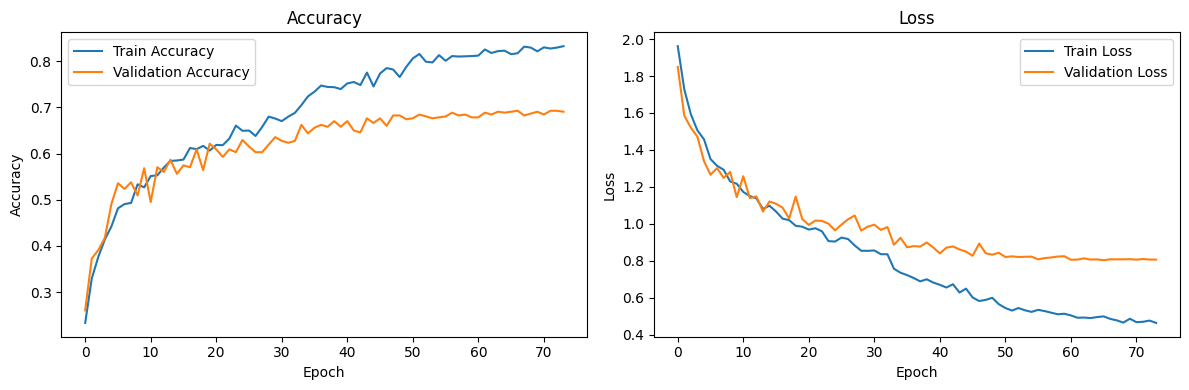

In [4]:
y_pred = mlp.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# === 9. Plot Accuracy and Loss ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Scanning /Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24: 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]
Scanning /Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]

Extracted 2452 features with 2452 labels.


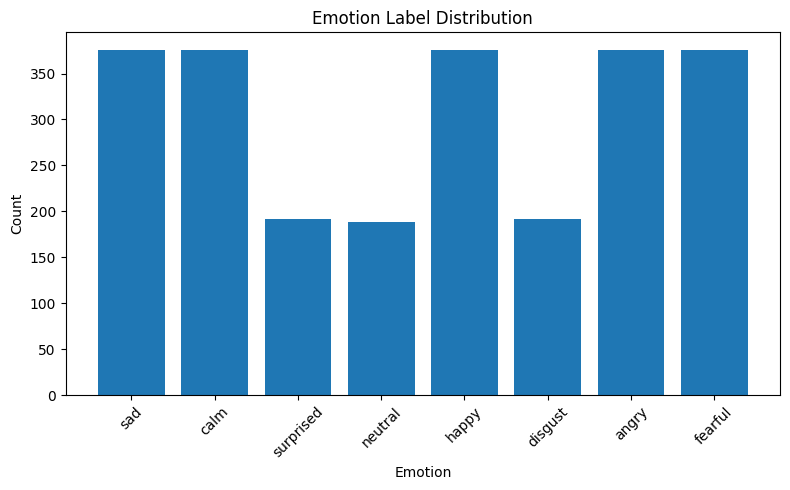

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Computed output size would be negative. Received `inputs shape=(None, 6, 64)`, `kernel shape=(8, 64, 128)`, `dilation_rate=[1]`.

In [8]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# === Emotion Mapping Based on RAVDESS ===
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# === Paths to Audio Folders ===
data_paths = [
     '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24',
     '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24'
]

# === Feature Extraction ===
mfcc_features = []
labels = []

for path in data_paths:
    for folder in tqdm(os.listdir(path), desc=f"Scanning {path}"):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path): continue
        for file in os.listdir(folder_path):
            if not file.endswith('.wav'): continue
            file_path = os.path.join(folder_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_scaled = np.mean(mfcc.T, axis=0)
                mfcc_features.append(mfcc_scaled)

                # Extract emotion from filename (3rd part)
                emotion_code = file.split('-')[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    labels.append(emotion)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

print(f"Extracted {len(mfcc_features)} features with {len(labels)} labels.")

# === Visualize Label Distribution ===
label_counts = {label: labels.count(label) for label in set(labels)}
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Emotion Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Encode Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# === Save Label Encoder ===
pickle.dump(le, open('label_encoder.pkl', 'wb'))

# === Scaling Features ===
X = np.array(mfcc_features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# === Split Dataset ===
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# === CNN Model ===
K.clear_session()
model = Sequential([
    Conv1D(64, kernel_size=8, activation='relu', input_shape=(x_train.shape[1], 1)),
    Conv1D(128, kernel_size=8, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.3),
    Conv1D(128, kernel_size=8, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.3),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# === Train ===
history = model.fit(x_train, y_train, validation_split=0.1, epochs=40, batch_size=32)

# === Predict and Evaluate ===
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# === Save Model and Scaler ===
model.save('emotion_cnn_model.h5')
pickle.dump(scaler, open('scaler.pkl', 'wb'))


Scanning /Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]
Scanning /Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s]


Extracted 2452 samples with 2452 valid labels.


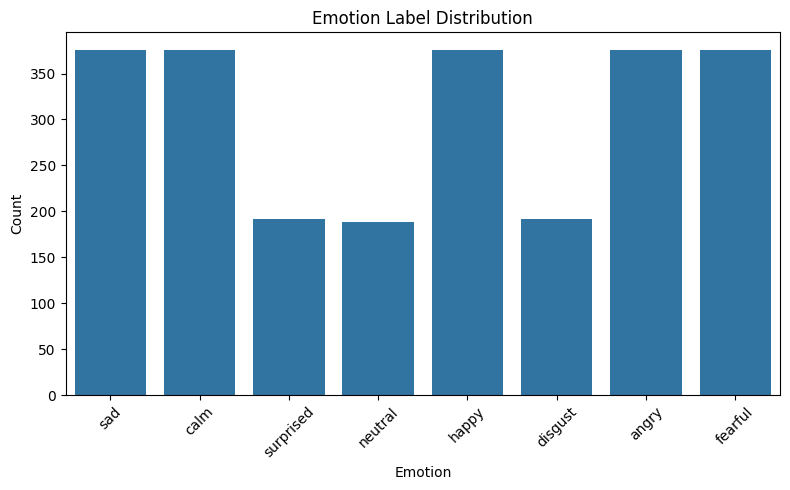

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,832 (429.03 KB)

 Trainable params: 109,576 (428.03 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1572 - loss: 2.1308 - val_accuracy: 0.1066 - val_loss: 2.0696
Epoch 2/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1673 - loss: 2.0514 - val_accuracy: 0.1066 - val_loss: 2.0589
Epoch 3/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2155 - loss: 1.9970 - val_accuracy: 0.1168 - val_loss: 2.0475
Epoch 4/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2470 - loss: 1.9185 - val_accuracy: 0.1117 - val_loss: 2.0258
Epoch 5/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2758 - loss: 1.8328 - val_accuracy: 0.1624 - val_loss: 1.9797
Epoch 6/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2965 - loss: 1.7779 - val_accuracy: 0.2284 - val_loss: 1.9138
Epoch 7/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3161 - loss: 1.7587 - val_accuracy: 0.3350 - val_loss: 1.8482
Epoch 8/90
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3361 - loss: 1.6786 - val_accuracy: 0.3959 - val_loss:


=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.82      0.67      0.74        75
        calm       0.59      0.80      0.68        75
     disgust       0.55      0.31      0.39        39
     fearful       0.48      0.65      0.55        75
       happy       0.67      0.63      0.65        75
     neutral       0.53      0.50      0.51        38
         sad       0.55      0.36      0.44        75
   surprised       0.47      0.59      0.52        39

    accuracy                           0.58       491
   macro avg       0.58      0.56      0.56       491
weighted avg       0.60      0.58      0.58       491


✅ Model, scaler, and label encoder saved successfully!


In [11]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# === Emotion Mapping Based on RAVDESS ===
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# === Paths to Audio Folders ===
data_paths = [
     '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24',
     '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24'
]

# === Feature Extraction ===
mfcc_features = []
labels = []

for path in data_paths:
    for folder in tqdm(os.listdir(path), desc=f"Scanning {path}"):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if not file.endswith('.wav'):
                continue
            file_path = os.path.join(folder_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_scaled = np.mean(mfcc.T, axis=0)
                mfcc_features.append(mfcc_scaled)

                # Extract emotion from filename (3rd part)
                emotion_code = file.split('-')[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    labels.append(emotion)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

print(f"\nExtracted {len(mfcc_features)} samples with {len(labels)} valid labels.")

# === Visualize Label Distribution ===
label_counts = {label: labels.count(label) for label in set(labels)}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Emotion Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Encode Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# === Save Label Encoder ===
pickle.dump(le, open('label_encoder.pkl', 'wb'))

# === Scale Features ===
X = np.array(mfcc_features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# === Train-Test Split ===
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# === CNN Model ===
K.clear_session()
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# === Train the Model ===
history = model.fit(x_train, y_train, validation_split=0.1, epochs=90, batch_size=32)

# === Predict & Evaluate ===
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# === Save Model & Scaler ===
model.save('emotion_cnn_model.h5')
pickle.dump(scaler, open('scaler.pkl', 'wb'))

print("\n✅ Model, scaler, and label encoder saved successfully!")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report:

              precision    recall  f1-score   support

       angry       0.83      0.80      0.82        75
        calm       0.73      0.72      0.72        75
     disgust       0.69      0.74      0.72        39
     fearful       0.69      0.67      0.68        75
       happy       0.63      0.69      0.66        75
     neutral       0.70      0.74      0.72        38
         sad       0.60      0.61      0.61        75
   surprised       0.62      0.51      0.56        39

    accuracy                           0.69       491
   macro avg       0.69      0.69      0.69       491
weighted avg       0.69      0.69      0.69       491



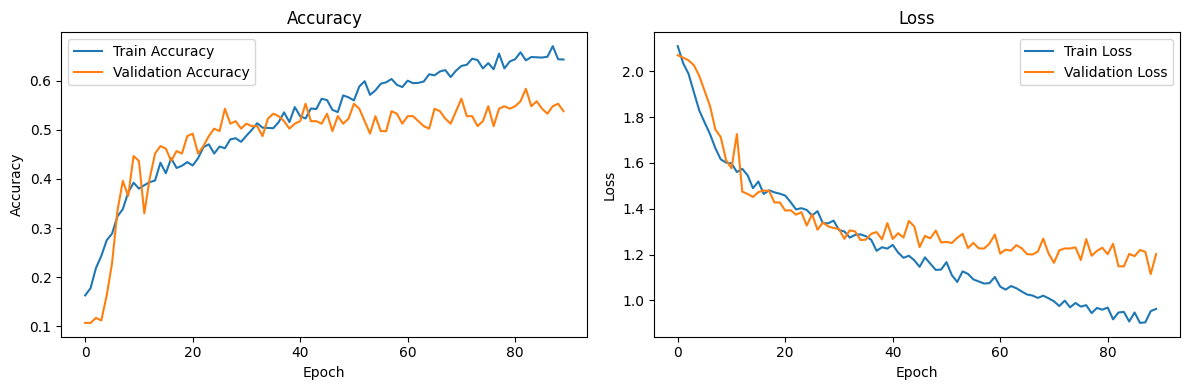

In [12]:
y_pred = mlp.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# === 9. Plot Accuracy and Loss ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
